# Self-Training với Điều chỉnh Ngưỡng τ

## Mục tiêu
- Huấn luyện **mô hình duy nhất** bằng **self-training** trên tập dữ liệu không nhãn
- **Thay đổi ngưỡng τ**: so sánh hiệu suất với các giá trị khác nhau (0.70, 0.80, 0.90, 0.95)
- **Chọn τ phù hợp**: dựa trên độ chính xác test set
- **Theo dõi chi tiết**: mỗi vòng, số mẫu được thêm, độ chính xác validation
- **Báo cáo toàn diện**: so sánh với baseline, phân tích per-class

## Self-Training Nguyên Lý
1. Huấn luyện mô hình ban đầu trên dữ liệu có nhãn
2. Dự đoán trên tập không nhãn
3. Chọn những dự đoán có **độ tin cậy cao** (confidence > τ)
4. Thêm vào tập huấn luyện và lặp lại

**Giả định**: mô hình có thể tự sửa lỗi khi được huấn luyện trên dữ liệu có nhãn tự dán


## Phần 1: Cấu Hình & Tải Dữ Liệu


In [1]:
# ==== Tham số của Papermill ====
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

# Self-training config
TAU_VALUES = [0.70, 0.80, 0.90, 0.95]  # Compare different thresholds
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output paths
HISTORY_PATH = "data/processed/history_self_training_detailed.csv"
COMPARISON_PATH = "data/processed/self_training_tau_comparison.csv"
BEST_METRICS_PATH = "data/processed/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_self_training_sample.csv"

# Best tau will be selected automatically based on test accuracy
BEST_TAU = None  # Will be determined during execution


In [2]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig,
    run_self_training,
    AQI_CLASSES,
    _normalize_missing,
    build_feature_columns
)

# Setup plotting
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print(f"Project root: {PROJECT_ROOT}")
print(f"AQI Classes: {AQI_CLASSES}")


Project root: C:\Code\DataMining\air_guard
AQI Classes: ['Good', 'Moderate', 'Unhealthy_for_Sensitive_Groups', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']


In [3]:
# Load dataset
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTarget distribution:\n{df['aqi_class'].value_counts(dropna=False)}")
print(f"\nMissing labels: {df['aqi_class'].isna().sum()} ({100*df['aqi_class'].isna().sum()/len(df):.1f}%)")


Dataset shape: (420768, 56)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'is_labeled']

Target distribution:
aqi_class
None                              384283
Unhealthy                          11484
Moderate                           10065
Unhealthy_for_Sensitive_Groups      5302
Very_Unhealthy                      5191
Hazardous                           2741
Good                                1702
Name: count, dtype: int64



## Phần 2: Huấn Luyện Baseline (Supervised)

Baseline được huấn luyện chỉ trên dữ liệu có nhãn (trước cutoff date).
Đây là điểm tham chiếu để đánh giá cải thiện từ self-training.


In [11]:
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=100, verbose=0))
])

print("\nTraining baseline classifier...")
baseline_model.fit(X_train, y_train)

y_test_pred = baseline_model.predict(X_test)

# Filter out None/NaN values from test set for evaluation
test_mask = y_test.notna()
y_test_filtered = y_test[test_mask]
y_test_pred_filtered = y_test_pred[test_mask]

baseline_test_acc = accuracy_score(y_test_filtered, y_test_pred_filtered)
baseline_test_f1 = f1_score(y_test_filtered, y_test_pred_filtered, average='macro', zero_division=0)
baseline_report = classification_report(y_test_filtered, y_test_pred_filtered, output_dict=True, zero_division=0)

print(f"\n✓ Baseline Test Accuracy: {baseline_test_acc:.4f}")
print(f"✓ Baseline Test F1-Macro: {baseline_test_f1:.4f}")
print(f"\nBaseline Classification Report:")
print(classification_report(y_test_filtered, y_test_pred_filtered, zero_division=0))


Training baseline classifier...

✓ Baseline Test Accuracy: 0.5979
✓ Baseline Test F1-Macro: 0.5028

Baseline Classification Report:
                                precision    recall  f1-score   support

                          Good       0.83      0.15      0.25      1032
                     Hazardous       0.82      0.56      0.67      1855
                      Moderate       0.60      0.87      0.71      4833
                     Unhealthy       0.59      0.63      0.61      4286
Unhealthy_for_Sensitive_Groups       0.40      0.13      0.19      2166
                Very_Unhealthy       0.54      0.63      0.58      2499

                      accuracy                           0.60     16671
                     macro avg       0.63      0.50      0.50     16671
                  weighted avg       0.60      0.60      0.57     16671



## Phần 3: Self-Training với Các Ngưỡng τ Khác Nhau

So sánh hiệu suất với τ = 0.70, 0.80, 0.90, 0.95


In [7]:
print("="*70)
print("SELF-TRAINING WITH DIFFERENT TAU VALUES")
print("="*70)

# Store results for each tau
st_results = {}  # {tau: {"history": df, "test_metrics": dict}}
tau_test_accuracies = {}
tau_test_f1s = {}

for tau in TAU_VALUES:
    print(f"\n{'='*70}")
    print(f"Training Self-Training with τ = {tau}")
    print(f"{'='*70}")
    
    # Setup config
    st_cfg = SelfTrainingConfig(
        tau=float(tau),
        max_iter=int(MAX_ITER),
        min_new_per_iter=int(MIN_NEW_PER_ITER),
        val_frac=float(VAL_FRAC),
    )
    
    # Run self-training
    result = run_self_training(
        df=df,
        data_cfg=data_cfg,
        st_cfg=st_cfg,
    )
    
    # Extract results
    history_df = pd.DataFrame(result["history"])
    test_metrics = result["test_metrics"]
    pred_df = result["pred_df"]
    
    st_results[tau] = {
        "history": history_df,
        "test_metrics": test_metrics,
        "pred_df": pred_df,
    }
    
    tau_test_accuracies[tau] = test_metrics["accuracy"]
    tau_test_f1s[tau] = test_metrics["f1_macro"]
    
    # Print results
    print(f"\nTest Results for τ = {tau}:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  F1-Macro: {test_metrics['f1_macro']:.4f}")
    print(f"\nTraining History:")
    print(history_df.to_string(index=False))

print(f"\n{'='*70}")
print("SUMMARY: Test Accuracy for Each TAU")
print(f"{'='*70}")
for tau in TAU_VALUES:
    print(f"τ = {tau:.2f}: Accuracy = {tau_test_accuracies[tau]:.4f}, F1 = {tau_test_f1s[tau]:.4f}")

# Select best tau
best_tau = max(TAU_VALUES, key=lambda t: tau_test_accuracies[t])
best_test_acc = tau_test_accuracies[best_tau]
best_test_f1 = tau_test_f1s[best_tau]
BEST_TAU = best_tau

print(f"\n✓✓✓ BEST τ = {best_tau} (Accuracy = {best_test_acc:.4f})")


SELF-TRAINING WITH DIFFERENT TAU VALUES

Training Self-Training with τ = 0.7

Test Results for τ = 0.7:
  Accuracy: 0.5781
  F1-Macro: 0.5051

Training History:
 iter  val_accuracy  val_f1_macro  unlabeled_pool  new_pseudo  tau
    1      0.722615      0.679270          383962      219745  0.7
    2      0.715043      0.683818          164217      122124  0.7
    3      0.710500      0.679078           42093       18618  0.7
    4      0.703937      0.669995           23475        5450  0.7
    5      0.707471      0.675907           18025        2724  0.7
    6      0.705452      0.672650           15301        1623  0.7
    7      0.678950      0.637866           13678        1415  0.7
    8      0.686270      0.648152           12263         674  0.7
    9      0.683746      0.646024           11589         492  0.7
   10      0.705704      0.673090           11097         644  0.7

Training Self-Training with τ = 0.8

Test Results for τ = 0.8:
  Accuracy: 0.5941
  F1-Macro: 0.5167


## Phần 4: Trực Quan Hóa Tiến Độ Self-Training

Hiển thị sự thay đổi độ chính xác, F1-score và số lượng mẫu pseudo-labeled qua các vòng.


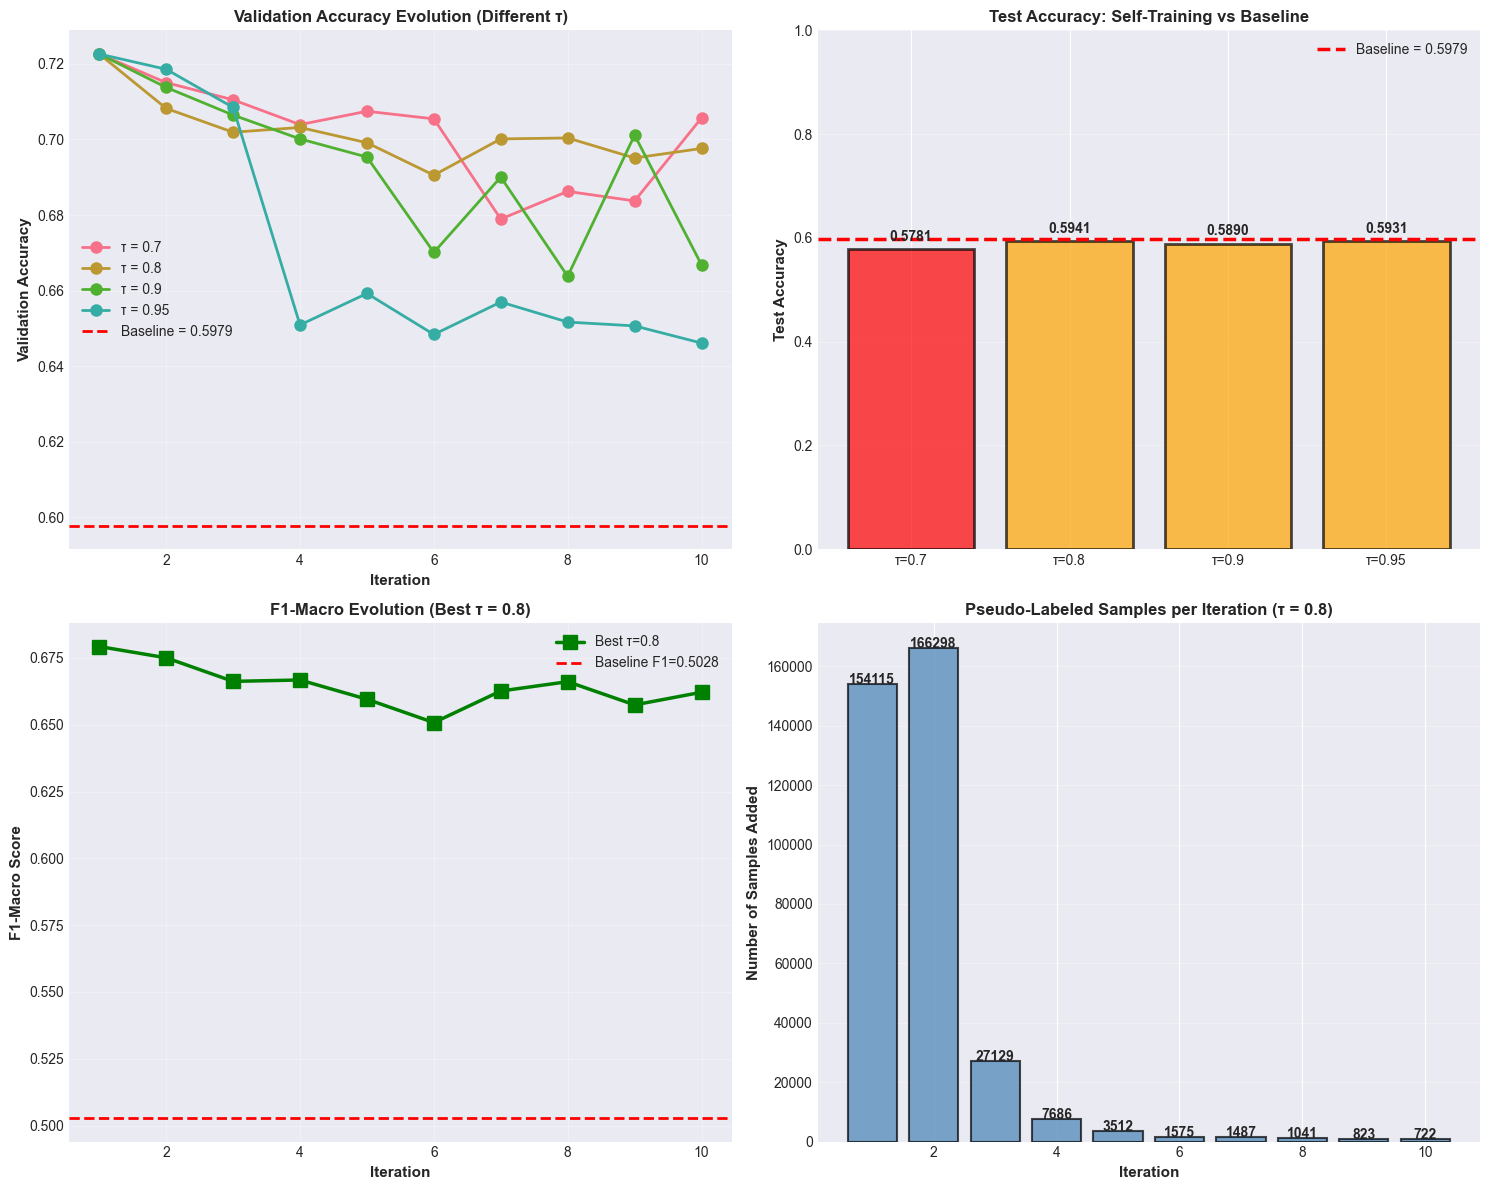

Plot saved to: notebooks/runs/self_training_tau_comparison.png


In [12]:
### 4.1: Validation Accuracy Evolution (All Taus)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Validation accuracy for each tau
ax = axes[0, 0]
for tau in TAU_VALUES:
    history = st_results[tau]["history"]
    ax.plot(history["iter"], history["val_accuracy"], "o-", label=f"τ = {tau}", linewidth=2, markersize=8)

ax.axhline(y=baseline_test_acc, color='r', linestyle='--', linewidth=2, label=f"Baseline = {baseline_test_acc:.4f}")
ax.set_xlabel("Iteration", fontsize=11, fontweight='bold')
ax.set_ylabel("Validation Accuracy", fontsize=11, fontweight='bold')
ax.set_title("Validation Accuracy Evolution (Different τ)", fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Test set accuracy comparison (bar chart)
ax = axes[0, 1]
taus_sorted = sorted(TAU_VALUES)
test_accs = [tau_test_accuracies[t] for t in taus_sorted]
colors = ['green' if acc > baseline_test_acc else 'orange' if acc >= baseline_test_acc - 0.01 else 'red' 
          for acc in test_accs]

bars = ax.bar([f"τ={t}" for t in taus_sorted], test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=baseline_test_acc, color='r', linestyle='--', linewidth=2.5, label=f"Baseline = {baseline_test_acc:.4f}")
ax.set_ylabel("Test Accuracy", fontsize=11, fontweight='bold')
ax.set_title("Test Accuracy: Self-Training vs Baseline", fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 3: F1-Macro evolution for best tau
ax = axes[1, 0]
history_best = st_results[BEST_TAU]["history"]
ax.plot(history_best["iter"], history_best["val_f1_macro"], "s-", label=f"Best τ={BEST_TAU}", 
        linewidth=2.5, markersize=10, color='green')
ax.axhline(y=baseline_test_f1, color='r', linestyle='--', linewidth=2, label=f"Baseline F1={baseline_test_f1:.4f}")
ax.set_xlabel("Iteration", fontsize=11, fontweight='bold')
ax.set_ylabel("F1-Macro Score", fontsize=11, fontweight='bold')
ax.set_title(f"F1-Macro Evolution (Best τ = {BEST_TAU})", fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Pseudo-labeled samples per iteration (best tau)
ax = axes[1, 1]
ax.bar(history_best["iter"], history_best["new_pseudo"], alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
ax.set_xlabel("Iteration", fontsize=11, fontweight='bold')
ax.set_ylabel("Number of Samples Added", fontsize=11, fontweight='bold')
ax.set_title(f"Pseudo-Labeled Samples per Iteration (τ = {BEST_TAU})", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (iter_val, count) in enumerate(zip(history_best["iter"], history_best["new_pseudo"])):
    ax.text(iter_val, count + 5, str(int(count)), ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/self_training_tau_comparison.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: notebooks/runs/self_training_tau_comparison.png")


In [13]:
### 4.2: Detailed Training Progression Table (Best τ)

print("\n" + "="*80)
print(f"TRAINING PROGRESSION (Best τ = {BEST_TAU})")
print("="*80)

history_best = st_results[BEST_TAU]["history"]
display_df = history_best[["iter", "val_accuracy", "val_f1_macro", "new_pseudo", "unlabeled_pool"]].copy()
display_df.columns = ["Iteration", "Val Accuracy", "Val F1-Macro", "Pseudo-Labeled", "Unlabeled Remaining"]

print(display_df.to_string(index=False))



TRAINING PROGRESSION (Best τ = 0.8)
 Iteration  Val Accuracy  Val F1-Macro  Pseudo-Labeled  Unlabeled Remaining
         1      0.722615      0.679270          154115               383962
         2      0.708228      0.675047          166298               229847
         3      0.701918      0.666222           27129                63549
         4      0.703180      0.666744            7686                36420
         5      0.699142      0.659539            3512                28734
         6      0.690560      0.650806            1575                25222
         7      0.700151      0.662619            1487                23647
         8      0.700404      0.666110            1041                22160
         9      0.695103      0.657425             823                21119
        10      0.697627      0.662147             722                20296


## Phần 5: Đánh Giá Tập Test & So Sánh với Baseline

### 5.1: Metrics Comparison


In [ ]:
# Get best self-training metrics
best_st_metrics = st_results[BEST_TAU]["test_metrics"]
best_st_report = best_st_metrics["report"]

print("\n" + "="*80)
print("TEST SET COMPARISON: BASELINE vs BEST SELF-TRAINING")
print("="*80)

# Overall metrics
print(f"\n{'Metric':<30} {'Baseline':<20} {'Self-Training':<20} {'Δ (Improvement)':<20}")
print("-" * 80)
print(f"{'Accuracy':<30} {baseline_test_acc:<20.4f} {best_st_metrics['accuracy']:<20.4f} {best_st_metrics['accuracy'] - baseline_test_acc:+.4f}")
print(f"{'F1-Macro':<30} {baseline_test_f1:<20.4f} {best_st_metrics['f1_macro']:<20.4f} {best_st_metrics['f1_macro'] - baseline_test_f1:+.4f}")

# Calculate percentage improvement
pct_acc_improvement = 100 * (best_st_metrics['accuracy'] - baseline_test_acc) / baseline_test_acc
pct_f1_improvement = 100 * (best_st_metrics['f1_macro'] - baseline_test_f1) / baseline_test_f1

print(f"\n{'Accuracy Improvement':<30} {pct_acc_improvement:+.2f}%")
print(f"{'F1-Macro Improvement':<30} {pct_f1_improvement:+.2f}%")

# Print full report (filter NaN values)
y_test_pred_all = baseline_model.predict(X_test)
test_mask = y_test.notna()
y_test_for_report = y_test[test_mask]
y_test_pred_for_report = y_test_pred_all[test_mask]

print("\n" + "="*80)
print("BASELINE CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_for_report, y_test_pred_for_report, zero_division=0))

print("\n" + "="*80)
print(f"SELF-TRAINING (τ={BEST_TAU}) CLASSIFICATION REPORT")
print("="*80)
print(best_st_metrics["report"])


TEST SET COMPARISON: BASELINE vs BEST SELF-TRAINING

Metric                         Baseline             Self-Training        Δ (Improvement)     
--------------------------------------------------------------------------------
Accuracy                       0.5979               0.5941               -0.0038
F1-Macro                       0.5028               0.5167               +0.0139

Accuracy Improvement           -0.63%
F1-Macro Improvement           +2.76%

BASELINE CLASSIFICATION REPORT


TypeError: '<' not supported between instances of 'str' and 'NoneType'